In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
# ---------- Graphics ------------
# matplotlib
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=0.5,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=4
rcParams['xtick.minor.width']=0.5
rcParams['xtick.minor.size']=2
rcParams['xtick.direction'] = "in"
rcParams['ytick.direction'] = "in"
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=4
rcParams['ytick.minor.width']=0.5
rcParams['ytick.minor.size']=2
import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
        sys.path.append("/Users/gks/programs/MCcubed2/MCcubed/")
    except Exception as e:
        print(e)
        print("Paths already removed")

import MCcubed as mc3   # Add path to mc3 if necessary
sys.path.append("/Users/Sophie/git/MCcubed/")
sys.path.append("../src/")

# Get data
df_ground = pd.read_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_ground.csv",sep=",",header=0)
df_k2 = pd.read_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_k2.csv",sep=",",header=0)

df_ground_k2_100b = pd.read_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_ground.csv",sep=",",header=0)
df_k2_k2_100b = pd.read_csv("../data/k2_100b/K2_data_k2_100b_for_plotting_k2.csv",sep=",",header=0)

df_ground_k2_104b = pd.read_csv("../data/k2_104b/K2_data_k2_104b_for_plotting_ground.csv",sep=",",header=0)
df_k2_k2_104b = pd.read_csv("../data/k2_104b/K2_data_k2_104b_for_plotting_k2.csv",sep=",",header=0)

In [7]:
from priors import PriorSet, UP, NP, JP
import trf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils
import allanvariancemc_modified 

/Users/gks/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


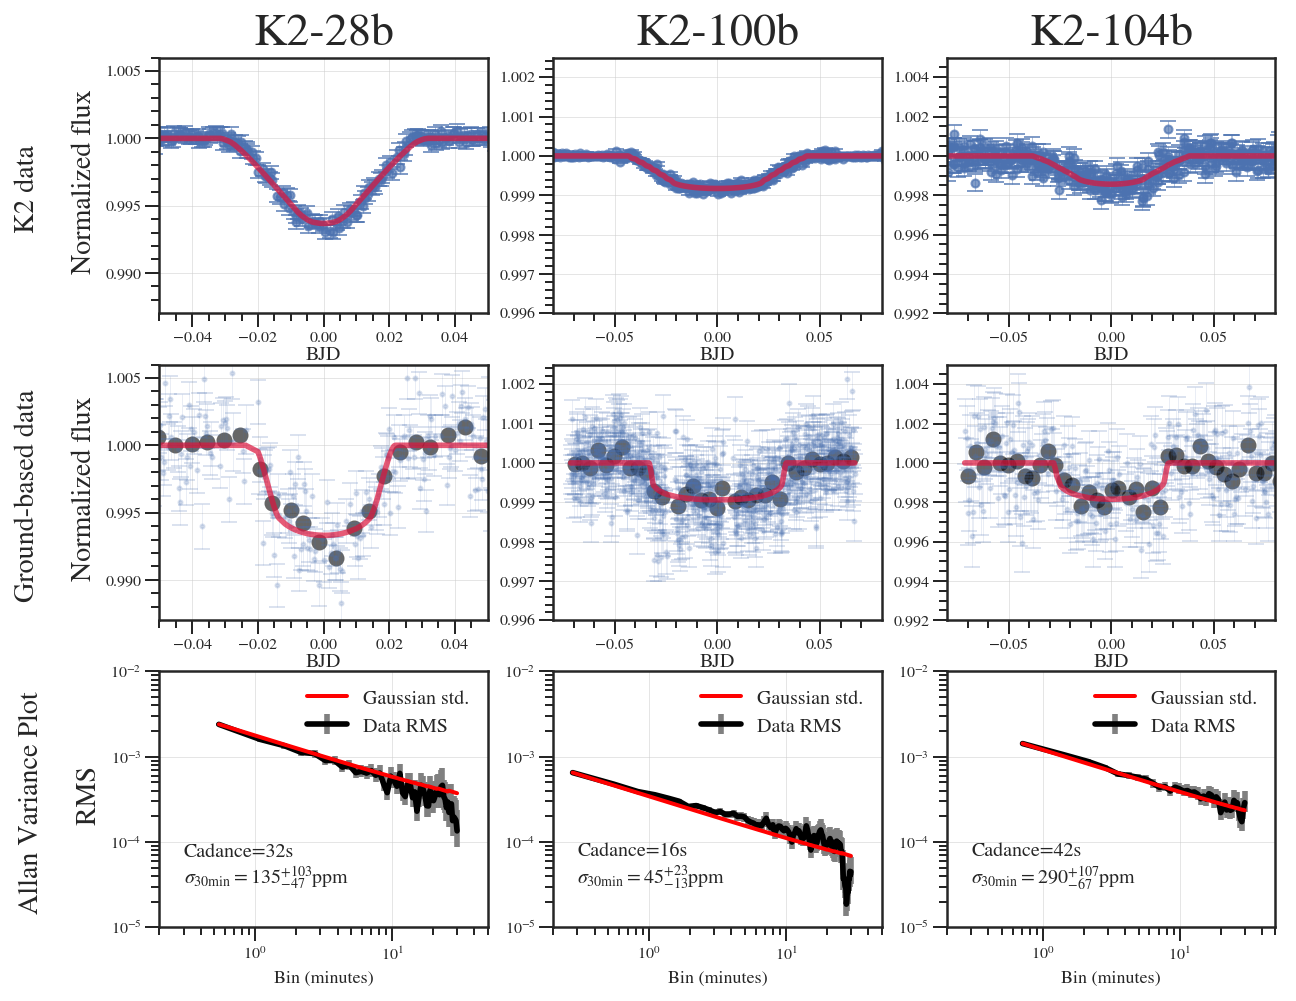

In [9]:
import plot_transits
# create a 9 panel plot
fig, axx = plt.subplots(nrows=3,ncols=3,figsize=(10,8))
(ax,bx,cx),(dx,ex,fx),(gx,hx,ix) = axx

p_k2_28b = 2.26050002261
p_k2_100b= 1.6739026
p_k2_104b= 1.97444281224

cadance_k2_28b = 32.5728267431
cadance_k2_100b= 16.5888056159
cadance_k2_104b= 42.5952024758

#k2-28b
k2_28_t0 = df_ground['xmodel_ground'][np.argmin(df_ground['ymodel_ground'])]

plot_transits.plot_transit_with_model(df_k2['phase_fold_time_k2']*p_k2_28b,
                        df_k2['phase_fold_scaled_flux_k2'],
                        df_k2['scaled_error_k2'],
                        yresidual=None,
                        #yresidual=df_k2['yresidual_k2'],
                        xmodel=df_k2['xmodel_k2']*p_k2_28b,
                        ymodel=df_k2['ymodel_k2'],ax=ax)
plot_transits.plot_transit_with_model(df_ground['time_ground']-k2_28_t0,
                        df_ground['scaled_flux_ground'],
                        df_ground['scaled_error_ground'],
                        yresidual=None,
                        #yresidual=df_ground['yresidual_ground'],
                        xmodel=df_ground['xmodel_ground']-k2_28_t0,
                        ymodel=df_ground['ymodel_ground'],
                        offset=0.975,ax=dx,alpha=0.2,markersize=2.)
df_k2_28b = utils.bin_data(df_ground['time_ground']-k2_28_t0,df_ground['scaled_flux_ground'],int(5.*60./cadance_k2_28b))
dx.plot(df_k2_28b.x,df_k2_28b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# (Sinusoidal) time-correlated signal:
red = np.array(df_ground['yresidual_ground'])
# Generate residuals signal:
N = len(red)
# White-noise signal:
white = np.random.normal(0, 5, N)
# Compute the residuals rms-vs-binsize:
maxbins = int(1800/cadance_k2_28b)
rms, rmslo, rmshi, stderr, binsz = mc3.rednoise.binrms(red, maxbins)
gx.errorbar(binsz*cadance_k2_28b/60., rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS",zorder=3)
gx.loglog(binsz*cadance_k2_28b/60., stderr, color='red', ls='-', lw=2, label="Gaussian std.",zorder=5)
handles,labels = gx.get_legend_handles_labels()
handles = [handles[0],  handles[1]]
labels = [labels[0],  labels[1]]
gx.legend(handles,labels,loc="upper right",fontsize=10)
gx.set_xlabel("Bin (minutes)", fontsize=9)
gx.set_ylabel("RMS", fontsize=9)
label_28b = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms[-1]*1e6,rmshi[-1]*1e6,rmslo[-1]*1e6)
gx.text(0.3,3e-5,'Cadance={}s\n'.format(int(cadance_k2_28b))+label_28b,fontsize=10)


#k2-100b
k2_100_t0 = df_ground_k2_100b['xmodel_ground'][np.argmin(df_ground_k2_100b['ymodel_ground'])]
plot_transits.plot_transit_with_model(df_k2_k2_100b['phase_fold_time_k2']*p_k2_100b,
                        df_k2_k2_100b['phase_fold_scaled_flux_k2'],
                        df_k2_k2_100b['scaled_error_k2'],
                        #yresidual=df_k2_k2_100b['yresidual_k2'],
                        yresidual=None,
                        xmodel=df_k2_k2_100b['xmodel_k2']*p_k2_100b,
                        ymodel=df_k2_k2_100b['ymodel_k2'],ax=bx,offset=0.9985)
plot_transits.plot_transit_with_model(df_ground_k2_100b['time_ground']-k2_100_t0,
                        df_ground_k2_100b['scaled_flux_ground'],
                        df_ground_k2_100b['scaled_error_ground'],
                        #yresidual=df_ground_k2_100b['yresidual_ground'],
                        yresidual=None,
                        xmodel=df_ground_k2_100b['xmodel_ground']-k2_100_t0,
                        ymodel=df_ground_k2_100b['ymodel_ground'],
                        offset=0.9925,ax=ex,alpha=0.2,markersize=2.)
df_k2_100b = utils.bin_data(df_ground_k2_100b['time_ground']-k2_100_t0,df_ground_k2_100b['scaled_flux_ground'],int(5.*60./cadance_k2_100b))
# HACK, take out bad datapoint ? Need to take a closer look at this..
df_k2_100b=df_k2_100b[df_k2_100b.y>0.998]
ex.plot(df_k2_100b.x,df_k2_100b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# (Sinusoidal) time-correlated signal:
red_100b = np.array(df_ground_k2_100b['yresidual_ground'])
# Generate residuals signal:
N_100b=len(red_100b)
# White-noise signal:
white_100b = np.random.normal(0, 5, N_100b)
# Compute the residuals rms-vs-binsize:
maxbins_100b = int(1800/cadance_k2_100b)
rms_100b, rmslo_100b, rmshi_100b, stderr_100b, binsz_100b = mc3.rednoise.binrms(red_100b, maxbins_100b)
hx.errorbar(binsz_100b*cadance_k2_100b/60., rms_100b, yerr=[rmslo_100b, rmshi_100b], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS",zorder=2)
hx.loglog(binsz_100b*cadance_k2_100b/60., stderr_100b, color='red', ls='-', lw=2, label="Gaussian std.",zorder=5)
handles_100b,labels_100b = hx.get_legend_handles_labels()
handles_100b = [handles_100b[0], handles_100b[1]]
labels_100b = [labels_100b[0], labels_100b[1]]
hx.legend(handles_100b,labels_100b,loc="upper right",fontsize=10)
hx.set_xlabel("Bin (minutes)", fontsize=9)
label_100b = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms_100b[-1]*1e6,rmshi_100b[-1]*1e6,rmslo_100b[-1]*1e6)
hx.set_ylabel("RMS", fontsize=9)
hx.text(0.3,3e-5,'Cadance={}s\n'.format(int(cadance_k2_100b))+label_100b,fontsize=10)

#avmc = allanvariancemc_modified.AllanVarianceMC()
#avmc.compute_noise(df_ground_k2_100b['yresidual_ground'])
#avmc.plot(ax=hx)


#k2-104b
k2_104_t0 = df_ground_k2_104b['xmodel_ground'][np.argmin(df_ground_k2_104b['ymodel_ground'])]
plot_transits.plot_transit_with_model(df_k2_k2_104b['phase_fold_time_k2']*p_k2_104b,
                        df_k2_k2_104b['phase_fold_scaled_flux_k2'],
                        df_k2_k2_104b['scaled_error_k2'],
                        #yresidual=df_k2_k2_104b['yresidual_k2'],
                        yresidual=None,
                        xmodel=df_k2_k2_104b['xmodel_k2']*p_k2_104b,
                        ymodel=df_k2_k2_104b['ymodel_k2'],offset=0.994,ax=cx)
plot_transits.plot_transit_with_model(df_ground_k2_104b['time_ground']-k2_104_t0,
                        df_ground_k2_104b['scaled_flux_ground'],
                        df_ground_k2_104b['scaled_error_ground'],
                        #yresidual=df_ground_k2_104b['yresidual_ground'],
                        yresidual=None,
                        xmodel=df_ground_k2_104b['xmodel_ground']-k2_104_t0,
                        ymodel=df_ground_k2_104b['ymodel_ground'],
                        offset=0.985,ax=fx,alpha=0.2,markersize=2.)
df_k2_104b = utils.bin_data(df_ground_k2_104b['time_ground']-k2_104_t0,df_ground_k2_104b['scaled_flux_ground'],int(5.*60./cadance_k2_104b))
# HACK, take out bad datapoint ? Need to take a closer look at this..
#df_k2_100b=df_k2_100b[df_k2_100b.y>0.998]
fx.plot(df_k2_104b.x,df_k2_104b.y,lw=0,marker="o",markersize=8,alpha=0.6,color="black",zorder=1)

# (Sinusoidal) time-correlated signal:
red_104b = np.array(df_ground_k2_104b['yresidual_ground'])
# Generate residuals signal:
N_104b = len(red_104b)
# White-noise signal:
white_104b = np.random.normal(0, 5, N_104b)
# Compute the residuals rms-vs-binsize:
maxbins_104b =int(30*60/cadance_k2_104b)
rms_104b, rmslo_104b, rmshi_104b, stderr_104b, binsz_104b = mc3.rednoise.binrms(red_104b, maxbins_104b)
label_104b = "$\sigma_{30\mathrm{min}} = %0.f^{+%0.f}_{-%0.f}$ppm" % (rms_104b[-1]*1e6,rmshi_104b[-1]*1e6,rmslo_104b[-1]*1e6)
ix.errorbar(binsz_104b*cadance_k2_104b/60., rms_104b, yerr=[rmslo_104b, rmshi_104b], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS",zorder=3)
ix.loglog(binsz_104b*cadance_k2_104b/60., stderr_104b, color='red', ls='-', lw=2, label="Gaussian std.",zorder=5)
handles_104b,labels_104b = ix.get_legend_handles_labels()
handles_104b = [handles_104b[0],  handles_104b[1]]
labels_104b = [labels_104b[0], labels_104b[1]]
ix.legend(handles_104b,labels_104b,loc="upper right",fontsize=10)
ix.set_xlabel("Bin (minutes)", fontsize=9)
ix.set_ylabel("RMS", fontsize=9)
ix.text(0.3,3e-5,'Cadance={}s\n'.format(int(cadance_k2_104b))+label_104b,fontsize=10)

axes = [ax,bx,cx,dx,fx,ex,gx,hx,ix]
[axx.tick_params(axis='both',labelsize=8,pad=2) for axx in axes];
       
ax.set_title("K2-28b")
bx.set_title("K2-100b")
cx.set_title("K2-104b") 
ax.set_ylabel("K2 data \n \n Normalized flux",fontsize=14)
dx.set_ylabel("Ground-based data \n \n Normalized flux",fontsize=14)
gx.set_ylabel("Allan Variance Plot \n \n RMS",fontsize=14)


for axx in [gx,hx,ix]:
    axx.set_ylim(1e-5,1e-2)
    axx.set_xlim(0.2,50.)
    #ix.set_ylim(0,10)

for axx in [bx,cx,ex,fx,hx,ix]:
    axx.set_ylabel("")
    
for axx in [ax,bx,cx,dx,ex,fx]:
    axx.set_xlabel("BJD",fontsize=10,labelpad=1)
    
for axx in axes:
    axx.grid(lw=0.5,alpha=0.5)

# K2-28b
ax.set_xlim(-0.05,0.05)
ax.set_ylim(0.987,1.006)
dx.set_xlim(-0.05,0.05)
dx.set_ylim(0.987,1.006)

# K2-100b
bx.set_xlim(-0.08,0.08)
bx.set_ylim(0.996,1.0025)
ex.set_xlim(-0.08,0.08)
ex.set_ylim(0.996,1.0025)

# K2-105b
cx.set_xlim(-0.08,0.08)
cx.set_ylim(0.992,1.005)
fx.set_xlim(-0.08,0.08)
fx.set_ylim(0.992,1.005)

#plt.tight_layout()
plt.savefig('../data/9_panel_plot.pdf',format='pdf')